In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%pylab inline
tau = 2.0 * pi

Populating the interactive namespace from numpy and matplotlib


In [3]:
from datetime import timedelta

from scipy.signal import argrelmax
from scipy.optimize import minimize_scalar
from scipy.optimize import brentq

import ephem
from iso8601 import parse_date

def datestr(s):
    return parse_date(s, default_timezone=None)

tle = """ISS
1 25544U 98067A   18171.89181005  .00001612  00000-0  31509-4 0  9992
2 25544  51.6423   0.2419 0002732 207.8583 302.1867 15.54203750119095
"""

line0, line1, line2 = tle.split('\n')[:3]

In [4]:
STEPS_PER_ORBIT = 6
ORBIT_FRACTION = 1.0 / 4  # fwd/back to guarantee a rise/set event
TOL = 0.01
HORIZON = 0.0
INTERVAL_SECONDS = 60*60*24*90

In [5]:
sat = ephem.readtle(line0, line1, line2)

gs = ephem.Observer()
# vu = ['Valparaiso University', '41.4639', '-87.0439', 245.089]
gs.name = 'Valparaisio University'
gs.lon = '-87.0439'
gs.lat = '41.4639'
gs.elevation = 245.1
gs.pressure = 0

start = datestr('2018-06-20 00:00:00')

In [6]:
def _sat_azel(dt):
    """time in seconds"""
    gs.date = start + timedelta(seconds=dt)
    sat.compute(gs)
    sat_azel.calls += 1
    return (sat.az*180.0/pi, sat.alt*180.0/pi)
sat_azel = np.vectorize(_sat_azel, cache=True)
sat_azel.calls = 0

Compute sat position relative to GS with `STEPS_PER_ORBIT` number of time increments for 90 days.

In [7]:



def find_passes(duration):
    #instrument function calls
    sat_azel.calls = 0

    # orbital period in seconds
    period = 24.0 * 60.0 * 60.0 / sat._n



    # coarse steps to find the points near (enough) to elevation peaks
    time_coarse = np.arange(0, INTERVAL_SECONDS, period/STEPS_PER_ORBIT)


    el_coarse = np.fromiter((sat_azel(dt)[1] for dt in time_coarse), np.float, time_coarse.size)

    peak_coarse_idx = argrelmax(el_coarse)[0]


    # find all local elevation maxima
    def fneg(dt):
        return -sat_azel(dt)[1]

    def truepeak(t, tol=0.1):
        r = minimize_scalar(
                fneg,
                bracket=(t-period/STEPS_PER_ORBIT, t+period/STEPS_PER_ORBIT),
                tol = tol/t)
        return (r.x, -r.fun)

    peak_true_times = np.zeros((len(peak_coarse_idx),))
    peak_el = np.zeros((len(peak_coarse_idx),))

    for i, dt in enumerate(time_coarse[peak_coarse_idx]):
        t, el = truepeak(dt)
        peak_true_times[i] = t
        peak_el[i] = el

    # select the visible passes
    visible_idx = np.where(peak_el > HORIZON)[0]
    visible_el = peak_el[visible_idx]
    visible_tca = peak_true_times[visible_idx]

    # find AOS events
    def f(t):
        return sat_azel(t)[1]

    def find_aos(t):
        a = (t - period*ORBIT_FRACTION)
        b = t
        return brentq(f, a, b, xtol=TOL)

    def find_los(t):
        a = t
        b = (t + period*ORBIT_FRACTION)
        return brentq(f, a, b, xtol=TOL)

    visible_aos = np.fromiter((find_aos(t) for t in visible_tca), np.float, len(visible_tca))
    visible_los = np.fromiter((find_los(t) for t in visible_tca), np.float, len(visible_tca))
    return (visible_aos, visible_tca, visible_los, visible_el, peak_true_times, peak_el)

(visible_aos, visible_tca, visible_los, visible_el, peak_true_times, peak_el) = find_passes(INTERVAL_SECONDS)

%timeit find_passes(INTERVAL_SECONDS)

2.81 s ± 8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [8]:
print('N passes:', len(visible_tca))
print('N calls:', sat_azel.calls)
print('Avg calls per found pass:', sat_azel.calls / len(visible_tca))

N passes: 618
N calls: 38842
Avg calls per found pass: 62.85113268608414


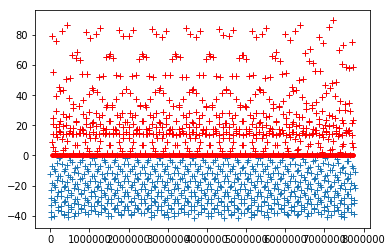

In [9]:
plot(peak_true_times, peak_el, '+')
plot(visible_tca, visible_el, '+r')
plot(visible_aos, np.zeros_like(visible_tca), '.r')
plot(visible_los, np.zeros_like(visible_tca), '.r')

# Find time to compute using pyephem.observer.next_pass()

In [10]:
import sys
sys.path.append('../python-files')

import db

In [11]:

observer = {
    'name':gs.name,
    'lat':gs.lat,
    'lon':gs.lon,
    'altitude':gs.elevation,
    'min_horizon': 0.0
}

satellite = {
    'name':line0,
    'tle':[line0, line1, line2],
}

passes = db.compute_passes_ephem([observer, satellite, start, len(visible_tca), INTERVAL_SECONDS/60])
%timeit -r1 -n1 passes = db.compute_passes_ephem([observer, satellite, start, len(visible_tca), INTERVAL_SECONDS/60])

Valparaisio University <--> ISS
Valparaisio University <--> ISS
2.85 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [12]:
# number of calls from an instrumented pyephem for these conditions
obj_cir_calls = 278228

Speedup factor and percentage reduction.

In [13]:
100 * ((38842 / 278228) - 1)

-86.03950716678408

In [14]:
1/(sat_azel.calls / 278228)

7.163070902631173

In [15]:
len(passes)

618

In [16]:
def td(time):
    return (time - start).total_seconds()

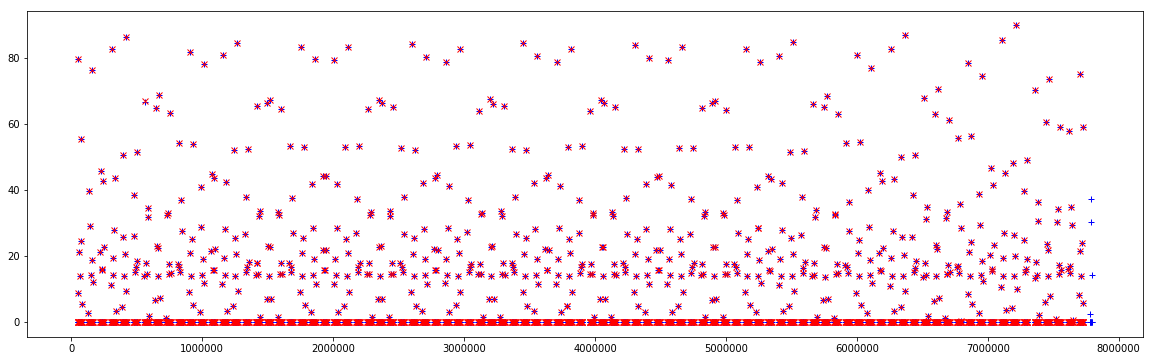

In [17]:

figure(figsize=(20, 6))

interactive(False)
for p in passes:
    aos = td(p.start)
    tca = td(p.tca)
    los = td(p.end)
    el = p.max_el
    plot(aos, 0.0, '+b')
    plot(tca, el, '+b')
    plot(los, 0.0, '+b')

plot(visible_aos, np.zeros_like(visible_aos), 'xr')
plot(visible_los, np.zeros_like(visible_aos), 'xr')
plot(visible_tca, visible_el, 'xr')
show()